In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%cd drive/MyDrive/University/Fourth\ Year/CISC_474_project_part_3

/content/drive/My Drive/University/Fourth Year/CISC_474_project_part_3


In [14]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/

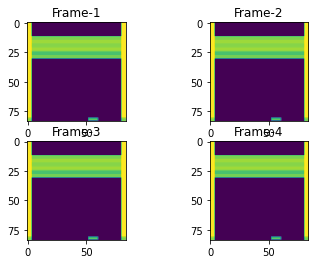

(84, 84, 4)


In [15]:
import numpy as np
import gym
import cv2
import matplotlib.pyplot as plt

# James Note: Importing deque for stack
from collections import deque


class Atari(object):
    def __init__(self, game: str, resized_width: int, resized_height: int, frame_skip=4, clip_reward: bool = True):
        """[summary]

        Args:
            game (str): [description]
            resized_width (int): [description]
            resized_height (int): [description]
            frame_skip (int, optional): [description]. Defaults to 4.
            clip_reward (bool, optional): [description]. Defaults to True.
        """
        self.env = gym.make(game)
        self.action_space_size = self.env.action_space.n  # The number of actions an agent can perform (int)
        self.resized_width = resized_width
        self.resized_height = resized_height

        # James Note: Added these two attrs for frame stacking
        self._frame_stack = deque([], frame_skip)
        self.frame_skip = frame_skip
        self.output = None

        # Also clip reward
        self.clip_reward = clip_reward

    def reset(self):
        """[summary]

        Returns:
            [type]: [description]
        """
        # Should reset the environment to the begining
        # Returns initial state
        # James Note: Implemented stacking from reset
        reset_obs = self.get_preprocessed_frame(self.env.reset())
        for _ in range(self.frame_skip):
            self._frame_stack.append(reset_obs)
        self.output = np.concatenate(self._frame_stack, axis=-1)
        return self.output

    def num_actions_available(self):
        """[summary]

        Returns:
            [type]: [description]
        """
        # Return total number of actions
        return self.env.action_space.n

    def get_preprocessed_frame(self, observation):
        """[summary]

        Args:
            observation ([type]): [description]

        Returns:
            [type]: [description]
        """

        # Convert image to grayscale
        # Rescale image
        # James Note: Rewrote this method to return a uint8 and expand the dims
        img = observation[34:-16, :, :]
        # Resize image
        img = cv2.resize(img, (84,84))
        # Grayscale
        img = img.mean(-1,keepdims=True)
        # Return as an unsigned integer to save space
        # Normalization occurs upon model input
        return img.astype("uint8")


    def get_action_meanings(self):
        """[summary]

        Returns:
            [type]: [description]
        """
        # Prints meaings of all possible actions
        return self.env.get_action_meanings()

    def step(self, action: int, plot_frames: bool = False) -> tuple:
        """[summary]
        Args:
            action (int): [description]
            frame_skip (int, optional): [description]. Defaults to 1.

        Returns:
            tuple: [description]
        """

        # Note from James
        # Frame skip was not implemented >>> Now it is (rewrote method)

        total_reward = 0
        second_to_last = None
        last = None
        for i in range(self.frame_skip):
            # take a step in the env and return the next state, reward,
            # and if the game is done as a tuple
            observation, reward, done, info = self.env.step(action)

            # Sum up the total reward
            total_reward += reward

            # Store the second to last frame
            if i == self.frame_skip - 1:
                last = self.get_preprocessed_frame(observation)
            elif i == self.frame_skip - 2:
                second_to_last = self.get_preprocessed_frame(observation)

        # Get the max of the last frame
        max_frame = np.array([second_to_last, last]).max(axis=0)

        # Append the newest frame
        self._frame_stack.append(max_frame)

        # If the num of stacks is correct then we concat
        assert len(self._frame_stack) == self.frame_skip or self.output is not None, "Must Reset Env To Step"
        self.output = np.concatenate(self._frame_stack, axis=-1)

        if plot_frames:
            import matplotlib.pyplot as plt
            f, axarr = plt.subplots(2,2)

            axarr[0,0].imshow((self.output[:, :, 0] / 255.0).astype(np.float32))
            axarr[0,0].set_title("Frame-1")

            axarr[0,1].imshow((self.output[:, :, 1] / 255.0).astype(np.float32))
            axarr[0,1].set_title("Frame-2")

            axarr[1,0].imshow((self.output[:, :, 2] / 255.0).astype(np.float32))
            axarr[1,0].set_title("Frame-3")

            axarr[1,1].imshow((self.output[:, :, 3] / 255.0).astype(np.float32))
            axarr[1,1].set_title("Frame-4")
            plt.show()

        # Clip the reward
        if self.clip_reward:
            total_reward = np.clip(total_reward, -1, 1)

        return self.output, total_reward, done, info

    def render(self):
        # Render the game state
        self.env.render()


if __name__ == "__main__":
    game = Atari("Breakout-v4", 84, 84)
    game.reset()
    print(game.step(0, plot_frames=True)[0].shape)

In [5]:
!pip install tensorflow==1.14.0
!pip install keras==2.3.1
!pip install keras-rl

In [ ]:
from __future__ import division
import argparse

from PIL import Image
import numpy as np
import gym

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

import rl
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

import matplotlib.pyplot as plt
import cv2

mode = "train"

WINDOW_LENGTH = 1


class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        return observation.astype('uint8')

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch.reshape((processed_batch.shape[0], 84, 84, 4))

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)



# Get the environment and extract the number of actions.
env = Atari("BreakoutNoFrameskip-v4", 84, 84, frame_skip=4)
np.random.seed(456)
env.env.seed(456)
nb_actions = env.action_space_size

# first layer takes in the 4 grayscale cropped image
input_lyr = keras.layers.Input((84, 84, 4), name="Input_last_4_frames")

# second layer convolves 16 8x8 then applies ReLU activation
x = keras.layers.Conv2D(16, (8,8), strides=4, name="Hidden_layer_1")(input_lyr)
x = keras.layers.Activation('relu')(x)

# third layer is the same but with 32 4x4 filters
x = keras.layers.Conv2D(32, (4,4), strides=2, name="Hidden_layer_2")(x)
x = keras.layers.Activation('relu')(x)

# James Note: Missing final dense hidden layer:
x = keras.layers.Flatten(name="Flatten")(x)
x = keras.layers.Dense(256, name="Hidden_layer_3")(x)
x = keras.layers.Activation('relu')(x)

# output layer is a fullyconnected linear layer
x = keras.layers.Dense(nb_actions, activation='linear')(x)

model = keras.Model(inputs=input_lyr, outputs=x, name="ATARI_DQN")


# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=250_000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

# Select a policy. We use eps-greedy action selection, which means that a random action is selected
# with probability eps. We anneal eps from 1.0 to 0.1 over the course of 1M steps. This is done so that
# the agent initially explores the environment (high eps) and then gradually sticks to what it knows
# (low eps). We also set a dedicated eps value that is used during testing. Note that we set it to 0.05
# so that the agent still performs some random actions. This ensures that the agent cannot get stuck.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=1000000)

# The trade-off between exploration and exploitation is difficult and an on-going research topic.
# If you want, you can experiment with the parameters or use a different policy. Another popular one
# is Boltzmann-style exploration:
# policy = BoltzmannQPolicy(tau=1.)
# Feel free to give it a try!

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=100_000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])

if mode == 'train':
    # Okay, now it's time to learn something! We capture the interrupt exception so that training
    # can be prematurely aborted. Notice that now you can use the built-in Keras callbacks!
    weights_filename = 'dqn_{}_weights_100k_250k_5m.h5f'.format("Breakout-v0")
    checkpoint_weights_filename = 'dqn_' + "Breakout-v0" + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format("Breakout-v0")
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
    callbacks += [FileLogger(log_filename, interval=5)]
    dqn.fit(env, callbacks=callbacks, nb_steps=5_000_000, log_interval=10000)

    # After training is done, we save the final weights one more time.
    dqn.save_weights(weights_filename, overwrite=True)

    # Finally, evaluate our algorithm for 10 episodes.
    dqn.test(env, nb_episodes=10, visualize=False)
elif mode == 'test':
    weights_filename = 'dqn_{}_weights.h5f'.format("Breakout-v0")
    if args.weights:
        weights_filename = args.weights
    dqn.load_weights(weights_filename)
    dqn.test(env, nb_episodes=10, visualize=True)

Training for 5000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 41s 4ms/step - reward: 0.0058
57 episodes - episode_reward: 1.000 [0.000, 7.000] - ale.lives: 2.933

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 42s 4ms/step - reward: 0.0071
53 episodes - episode_reward: 1.340 [0.000, 4.000] - ale.lives: 2.971

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 42s 4ms/step - reward: 0.0054
58 episodes - episode_reward: 0.948 [0.000, 5.000] - ale.lives: 2.940

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: 0.0054
59 episodes - episode_reward: 0.915 [0.000, 3.000] - ale.lives: 2.934

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 40s 4ms/step - reward: 0.0060
57 episodes - episode_reward: 1.053 [0.000, 4.000] - ale.lives: 3.024

Interval 6 (50000 steps performed)
10000/10000 [==========

In [1]:
model.save("q_agent_model.h5")

NameError: ignored

In [ ]:
""